#Enunciado

*  Crie a sua heurística **para escolher a melhor característica para um nó de uma árvore de decisão** e compare com a implementação feita nos vídeos postados nesse tópico aqui no AVA e com a implementação do scikit learn.

*  Faça comparações plotando as regiões de decisão com resubstituição para a base iris e as características usadas nos vídeos.

*  Também faça comparações usando validação cruzada com pelo menos 3 bases de classificação com atributos contínuos.

*  Escreva um parágrafo expondo sua interpretação dos resultados obtidos.

#Preparação

In [1]:
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
import zipfile
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_validate

In [2]:
iris = load_iris()
iris.feature_names,iris.target_names

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

In [3]:
X, y = iris.data[:,2:], iris.target
X.shape, y.shape

((150, 2), (150,))

In [4]:
combinacoes = 1
for i in range(X.shape[1]):
    valores = set(X[:,i])
    combinacoes *= len(valores)
    print(valores)
print(combinacoes)

{1.7, 1.4, 1.6, 1.3, 1.5, 1.1, 1.2, 1.0, 1.9, 4.7, 4.5, 4.9, 4.0, 5.0, 6.0, 3.5, 3.0, 4.6, 4.4, 4.1, 5.1, 5.9, 5.6, 5.5, 5.4, 6.6, 6.1, 6.9, 6.4, 3.6, 3.3, 3.8, 3.7, 4.2, 4.8, 4.3, 5.8, 5.3, 5.7, 5.2, 6.3, 6.7, 3.9}
{0.2, 0.4, 0.3, 0.5, 0.6, 1.4, 1.5, 1.3, 1.6, 1.0, 1.1, 2.5, 2.0, 2.1, 1.2, 1.7, 0.1, 2.2, 2.3, 1.8, 1.9, 2.4}
946



#Heurística própria

In [5]:
#OPÇÕES
#Gini
#Entropia
#Chi quadrado

def impureza_new(y): #Utilizada Entropia no lugar de Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    
    for i,k in enumerate(labels):
        sucesso = sum(y==k)/len(y)
        #falha = sum(y!=k)/len(y)
        #probabilidades[i] = -sucesso*np.log2(sucesso)-falha*np.log2(falha) #prob sucesso
        probabilidades[i] = -(sucesso)*np.log2(sucesso)
    result = sum(probabilidades)
    return result

ytmp = y[:]
valor = impureza_new(ytmp)
valor

1.584962500721156

In [6]:
def impurezaValor_new(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza_new(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza_new(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores
impurezaValor_new(X[:,0], y, 2.5)

(0.6666666666666666, 1.0, 0.0)

In [7]:
def melhorValor_new(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
   
    #lista para cálculo da mediana dos valores que contém a mediana do x e os valores de min e max encontrados durante a execução
    xlist = []
    xlist.append(np.median(x))

    while True:
        valor = np.median(xlist) #np.median(x) ##stats.mode(x)[0][0]

        impTotal, impMaiores, impMenores = impurezaValor_new(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
        
        xlist.append(xmax)
        xlist.append(xmin)

    return result, menorImpureza
melhorValor_new(X[:,0], y)

(4.35, 0.9182958340544896)

In [8]:
def melhorCaracteristica_new(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor_new(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]
print(melhorCaracteristica_new(X,y))

(1, 1.3, 0.9159794717999729)


In [9]:
def maisFrequente_new(y):
    return Counter(y.flat).most_common(1)[0][0]

In [10]:
class Arvore_new(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica_new(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore_new()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore_new()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente_new(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = Arvore_new()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(0.9933333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

#Implementação da vídeo aula para comparação

In [11]:
def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

ytmp = y[:]
valor = impureza(ytmp)
valor

0.6666666666666667

In [12]:
def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores
impurezaValor(X[:,0], y, 2.5)

(0.3333333333333333, 0.5, 0.0)

In [13]:
def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza
melhorValor(X[:,0], y)

(2.475, 0.3333333333333333)

In [14]:
def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]
print(melhorCaracteristica(X,y))

(0, 2.475, 0.3333333333333333)


In [15]:
def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(0.9933333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

#Comparação regiões decisão

In [16]:
def plotDecisao(modelo, X, y, titulo):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.title(titulo)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
        
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()

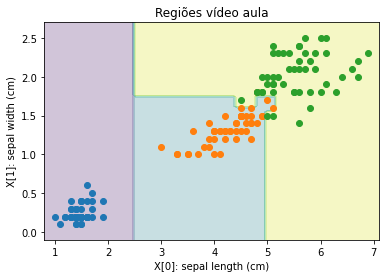

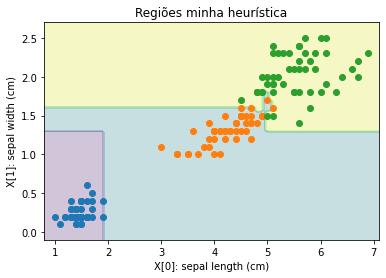

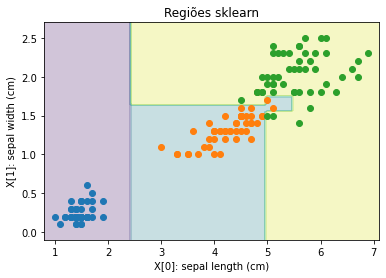

In [17]:
plotDecisao(Arvore(), X, y, "Regiões vídeo aula")
plotDecisao(Arvore_new(), X, y, "Regiões minha heurística")
plotDecisao(DecisionTreeClassifier(), X, y, "Regiões sklearn")

In [18]:
scores_iris_video_aula = cross_validate(Arvore(), X, y)
scores_iris_rodrigo = cross_validate(Arvore_new(), X, y)
scores_iris_sklearn = cross_validate(DecisionTreeClassifier(), X, y)

In [19]:
resultados = []
resultados.append(("Iris","Vídeo aula",np.mean(scores_iris_video_aula['test_score'])))
resultados.append(("Iris","Rodrigo",np.mean(scores_iris_rodrigo['test_score'])))
resultados.append(("Iris","Sklearn",np.mean(scores_iris_sklearn['test_score'])))

In [20]:
scores_iris_video_aula['test_score'], np.mean(scores_iris_video_aula['test_score'])

(array([0.96666667, 0.96666667, 0.9       , 0.93333333, 1.        ]),
 0.9533333333333334)

In [21]:
scores_iris_rodrigo['test_score'], np.mean(scores_iris_rodrigo['test_score'])

(array([0.96666667, 0.96666667, 0.83333333, 0.9       , 1.        ]),
 0.9333333333333332)

In [22]:
scores_iris_sklearn['test_score'], np.mean(scores_iris_sklearn['test_score'])

(array([0.96666667, 0.96666667, 0.9       , 0.93333333, 1.        ]),
 0.9533333333333334)

#Comparação em outras bases de dados com atributos contínuos usando validação cruzada

##Base 01 - Banknote authentication dataset
* https://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [23]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt

--2020-12-17 23:34:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46400 (45K) [application/x-httpd-php]
Saving to: ‘data_banknote_authentication.txt.11’

data_banknote_authe 100%[===================>]  45.31K  --.-KB/s    in 0.1s    

2020-12-17 23:34:45 (350 KB/s) - ‘data_banknote_authentication.txt.11’ saved [46400/46400]



In [24]:
df_banknote = pd.read_csv('data_banknote_authentication.txt')
df_banknote.columns = ["variance","skewness","curtosis","entropy","class"]

In [25]:
df_banknote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371 entries, 0 to 1370
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1371 non-null   float64
 1   skewness  1371 non-null   float64
 2   curtosis  1371 non-null   float64
 3   entropy   1371 non-null   float64
 4   class     1371 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [26]:
df_banknote.head()

,variance,skewness,curtosis,entropy,class
0,4.54590,8.1674,-2.4586,-1.46210,0
1,3.86600,-2.6383,1.9242,0.10645,0
2,3.45660,9.5228,-4.0112,-3.59440,0
3,0.32924,-4.4552,4.5718,-0.98880,0
4,4.36840,9.6718,-3.9606,-3.16250,0


In [27]:
X_banknote = np.array(df_banknote.drop(["class"], axis=1))[:,2:]
y_banknote = np.array(df_banknote["class"].values)

X_banknote.shape, y_banknote.shape, np.transpose(set(y_banknote))

((1371, 2), (1371,), array({0, 1}, dtype=object))

In [28]:
#df_banknote.drop(["class"], axis=1).describe()

In [29]:
melhor_feature_prof_banknote = melhorCaracteristica(X_banknote, y_banknote)
melhor_feature_rodrigo_banknote = melhorCaracteristica_new(X_banknote, y_banknote)

arvore_banknote = DecisionTreeClassifier()
arvore_banknote.fit(X_banknote,y_banknote)
melhor_feature_sklearn_banknote = np.argmax(arvore_banknote.feature_importances_), max(arvore_banknote.feature_importances_), arvore_banknote.tree_.impurity[np.argmax(arvore_banknote.feature_importances_)]

melhor_feature_prof_banknote, melhor_feature_rodrigo_banknote, melhor_feature_sklearn_banknote

((0, 6.320649999999999, 0.4728161372623945),
 (1, -0.58665, 0.9901267029949467),
 (0, 0.5873446829924446, 0.4939347460499106))

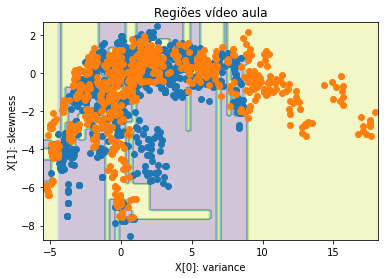

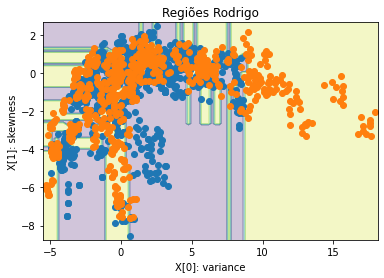

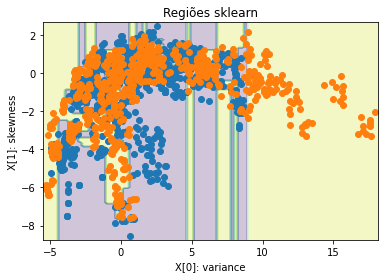

In [30]:
def plotDecisao_banknote(modelo, X, y, title):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.title(title)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{y_banknote[k]} [{k}]")
    
    plt.xlabel(f"X[0]: {df_banknote.keys()[0]}")
    plt.ylabel(f"X[1]: {df_banknote.keys()[1]}")
    plt.show()


plotDecisao_banknote(Arvore(), X_banknote, y_banknote, "Regiões vídeo aula")
plotDecisao_banknote(Arvore_new(), X_banknote, y_banknote, "Regiões Rodrigo")
plotDecisao_banknote(DecisionTreeClassifier(), X_banknote, y_banknote, "Regiões sklearn")

In [31]:
scores_banknote_video_aula = cross_validate(Arvore(), X_banknote, y_banknote)
scores_banknote_rodrigo = cross_validate(Arvore_new(), X_banknote, y_banknote)
scores_banknote_sklearn = cross_validate(DecisionTreeClassifier(), X_banknote, y_banknote)

In [32]:
resultados.append(("Banknote","Vídeo aula",np.mean(scores_banknote_video_aula['test_score'])))
resultados.append(("Banknote","Rodrigo",np.mean(scores_banknote_rodrigo['test_score'])))
resultados.append(("Banknote","Sklearn",np.mean(scores_banknote_sklearn['test_score'])))

In [33]:
scores_banknote_video_aula['test_score'], np.mean(scores_banknote_video_aula['test_score'])

(array([0.71636364, 0.69343066, 0.71532847, 0.67153285, 0.67518248]),
 0.6943676177836762)

In [34]:
scores_banknote_rodrigo['test_score'], np.mean(scores_banknote_rodrigo['test_score'])

(array([0.67636364, 0.66788321, 0.70437956, 0.68248175, 0.6459854 ]),
 0.6754187126741872)

In [35]:
scores_banknote_sklearn['test_score'], np.mean(scores_banknote_sklearn['test_score'])

(array([0.73818182, 0.68978102, 0.70437956, 0.70072993, 0.65328467]),
 0.697271400132714)

##Base 02 - Cryotherapy dataset
* https://archive.ics.uci.edu/ml/datasets/Cryotherapy+Dataset+

In [36]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00429/Cryotherapy.xlsx

--2020-12-17 23:34:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00429/Cryotherapy.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33589 (33K) [application/x-httpd-php]
Saving to: ‘Cryotherapy.xlsx.10’

Cryotherapy.xlsx.10 100%[===================>]  32.80K  --.-KB/s    in 0.07s   

2020-12-17 23:34:58 (494 KB/s) - ‘Cryotherapy.xlsx.10’ saved [33589/33589]



In [37]:
df_cryo = pd.read_excel('Cryotherapy.xlsx')

In [38]:
df_cryo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sex                  90 non-null     int64  
 1   age                  90 non-null     int64  
 2   Time                 90 non-null     float64
 3   Number_of_Warts      90 non-null     int64  
 4   Type                 90 non-null     int64  
 5   Area                 90 non-null     int64  
 6   Result_of_Treatment  90 non-null     int64  
dtypes: float64(1), int64(6)
memory usage: 5.0 KB


In [39]:
df_cryo

,sex,age,Time,Number_of_Warts,Type,Area,Result_of_Treatment
0,1,35,12.00,5,1,100,0
1,1,29,7.00,5,1,96,1
2,1,50,8.00,1,3,132,0
3,1,32,11.75,7,3,750,0
4,1,67,9.25,1,1,42,0
...,...,...,...,...,...,...,...
85,2,34,12.00,3,3,95,0
86,2,20,3.50,6,1,75,1
87,2,35,8.25,8,3,100,0
88,1,24,10.75,10,1,20,1


In [40]:
X_cryo = np.array(df_cryo.drop(["sex","Number_of_Warts","Type","Area","Result_of_Treatment"], axis=1))
y_cryo = np.array(df_cryo["Result_of_Treatment"].values)

X_cryo.shape, y_cryo.shape, np.transpose(set(y_cryo))

((90, 2), (90,), array({0, 1}, dtype=object))

In [41]:
melhor_feature_prof_cryo = melhorCaracteristica(X_cryo, y_cryo)
melhor_feature_rodrigo_cryo = melhorCaracteristica_new(X_cryo, y_cryo)

arvore_cryo = DecisionTreeClassifier()
arvore_cryo.fit(X_cryo,y_cryo)
melhor_feature_sklearn_cryo = np.argmax(arvore_cryo.feature_importances_), max(arvore_cryo.feature_importances_), arvore_cryo.tree_.impurity[np.argmax(arvore_cryo.feature_importances_)]

melhor_feature_prof_cryo, melhor_feature_rodrigo_cryo, melhor_feature_sklearn_cryo

((1, 6.125, 0.32387955182072836),
 (1, 8.5, 0.6199404705213222),
 (1, 0.5984369222102475, 0.16873985938345049))

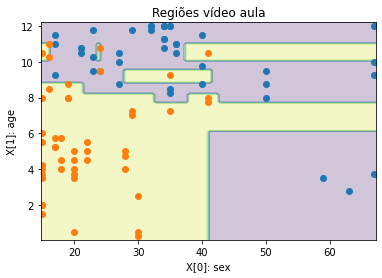

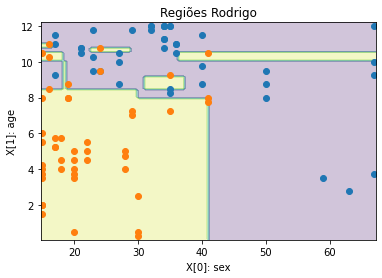

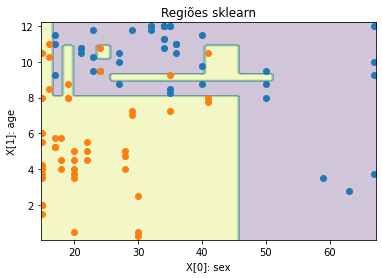

In [42]:
def plotDecisao_cryo(modelo, X, y, title):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.title(title)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{y_cryo[k]} [{k}]")
    plt.xlabel(f"X[0]: {df_cryo.keys()[0]}")
    plt.ylabel(f"X[1]: {df_cryo.keys()[1]}")
    plt.show()

plotDecisao_cryo(Arvore(), X_cryo, y_cryo, "Regiões vídeo aula")
plotDecisao_cryo(Arvore_new(), X_cryo, y_cryo, "Regiões Rodrigo")
plotDecisao_cryo(DecisionTreeClassifier(), X_cryo, y_cryo, "Regiões sklearn")

In [43]:
scores_cryo_video_aula = cross_validate(Arvore(), X_cryo, y_cryo)
scores_cryo_rodrigo = cross_validate(Arvore_new(), X_cryo, y_cryo)
scores_cryo_sklearn = cross_validate(DecisionTreeClassifier(), X_cryo, y_cryo)

In [44]:
resultados.append(("Cryotherapy","Vídeo aula",np.mean(scores_cryo_video_aula['test_score'])))
resultados.append(("Cryotherapy","Rodrigo",np.mean(scores_cryo_rodrigo['test_score'])))
resultados.append(("Cryotherapy","Sklearn",np.mean(scores_cryo_sklearn['test_score'])))

In [45]:
scores_cryo_video_aula['test_score'], np.mean(scores_cryo_video_aula['test_score'])

(array([0.88888889, 0.66666667, 0.94444444, 0.77777778, 0.77777778]),
 0.8111111111111111)

In [46]:
scores_cryo_rodrigo['test_score'], np.mean(scores_cryo_rodrigo['test_score'])

(array([0.94444444, 0.77777778, 1.        , 0.72222222, 0.83333333]),
 0.8555555555555555)

In [47]:
scores_cryo_sklearn['test_score'], np.mean(scores_cryo_sklearn['test_score'])

(array([0.88888889, 0.77777778, 1.        , 0.83333333, 0.83333333]),
 0.8666666666666666)

##Base 03 - Vertebral column dataset
* https://archive.ics.uci.edu/ml/datasets/Vertebral+Column  

In [48]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip

--2020-12-17 23:35:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33251 (32K) [application/x-httpd-php]
Saving to: ‘vertebral_column_data.zip.10’

vertebral_column_da 100%[===================>]  32.47K  --.-KB/s    in 0.07s   

2020-12-17 23:35:00 (487 KB/s) - ‘vertebral_column_data.zip.10’ saved [33251/33251]



In [49]:
#UNZIP FILE
zf = zipfile.ZipFile('vertebral_column_data.zip')
zf.extractall()

In [50]:
df_vert = pd.read_csv("column_3C.dat",delimiter=" ")
df_vert.columns=["pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle","sacral_slope","pelvic_radius","degree_spondylolisthesis","class"]

In [51]:
df_vert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          309 non-null    float64
 1   pelvic_tilt               309 non-null    float64
 2   lumbar_lordosis_angle     309 non-null    float64
 3   sacral_slope              309 non-null    float64
 4   pelvic_radius             309 non-null    float64
 5   degree_spondylolisthesis  309 non-null    float64
 6   class                     309 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.0+ KB


In [52]:
df_vert

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,39.06,10.06,25.02,29.00,114.41,4.56,DH
1,68.83,22.22,50.09,46.61,105.99,-3.53,DH
2,69.30,24.65,44.31,44.64,101.87,11.21,DH
3,49.71,9.65,28.32,40.06,108.17,7.92,DH
4,40.25,13.92,25.12,26.33,130.33,2.23,DH
...,...,...,...,...,...,...,...
304,47.90,13.62,36.00,34.29,117.45,-4.25,NO
305,53.94,20.72,29.22,33.22,114.37,-0.42,NO
306,61.45,22.69,46.17,38.75,125.67,-2.71,NO
307,45.25,8.69,41.58,36.56,118.55,0.21,NO


In [53]:
ord_enc = OrdinalEncoder()
df_vert["class"] = ord_enc.fit_transform(df_vert[["class"]]).astype(int)

df_vert

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,39.06,10.06,25.02,29.00,114.41,4.56,0
1,68.83,22.22,50.09,46.61,105.99,-3.53,0
2,69.30,24.65,44.31,44.64,101.87,11.21,0
3,49.71,9.65,28.32,40.06,108.17,7.92,0
4,40.25,13.92,25.12,26.33,130.33,2.23,0
...,...,...,...,...,...,...,...
304,47.90,13.62,36.00,34.29,117.45,-4.25,1
305,53.94,20.72,29.22,33.22,114.37,-0.42,1
306,61.45,22.69,46.17,38.75,125.67,-2.71,1
307,45.25,8.69,41.58,36.56,118.55,0.21,1


In [54]:
df_vert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          309 non-null    float64
 1   pelvic_tilt               309 non-null    float64
 2   lumbar_lordosis_angle     309 non-null    float64
 3   sacral_slope              309 non-null    float64
 4   pelvic_radius             309 non-null    float64
 5   degree_spondylolisthesis  309 non-null    float64
 6   class                     309 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 17.0 KB


In [55]:
X_vert = np.array(df_vert.drop(["pelvic_incidence","pelvic_tilt","sacral_slope","pelvic_radius","class"], axis=1))
y_vert = np.array(df_vert["class"].values)

X_vert.shape, y_vert.shape, np.transpose(set(y_vert))

((309, 2), (309,), array({0, 1, 2}, dtype=object))

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_vert = scaler.fit_transform(X_vert)

In [57]:
melhor_feature_prof_vert = melhorCaracteristica(X_vert, y_vert)
melhor_feature_rodrigo_vert = melhorCaracteristica_new(X_vert, y_vert)

arvore_vert = DecisionTreeClassifier()
arvore_vert.fit(X_vert,y_vert)
melhor_feature_sklearn_vert = np.argmax(arvore_vert.feature_importances_), max(arvore_vert.feature_importances_), arvore_vert.tree_.impurity[np.argmax(arvore_vert.feature_importances_)]

melhor_feature_prof_vert, melhor_feature_rodrigo_vert, melhor_feature_sklearn_vert

((0, 0.9654236625002697, 0.557116117504467),
 (1, -0.38138182022588485, 0.7218581443968414),
 (1, 0.8033816592254606, 0.5017553335133675))

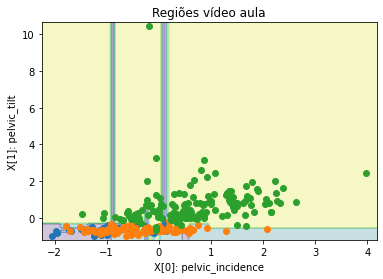

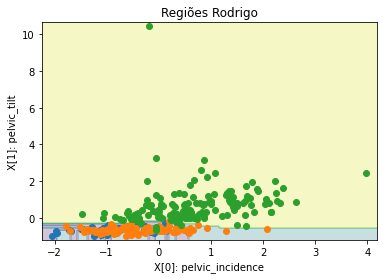

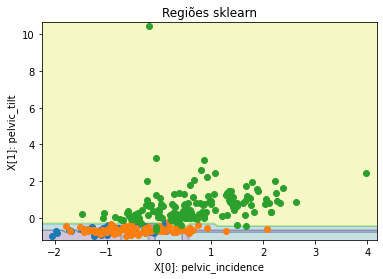

In [58]:
def plotDecisao_vert(modelo, X, y, title):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.title(title)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{y_vert[k]} [{k}]")
    plt.xlabel(f"X[0]: {df_vert.keys()[0]}")
    plt.ylabel(f"X[1]: {df_vert.keys()[1]}")
    plt.show()


plotDecisao_vert(Arvore(), X_vert, y_vert, "Regiões vídeo aula")
plotDecisao_vert(Arvore_new(), X_vert, y_vert, "Regiões Rodrigo")
plotDecisao_vert(DecisionTreeClassifier(), X_vert, y_vert, "Regiões sklearn")

In [59]:
scores_vert_video_aula = cross_validate(Arvore(), X_vert, y_vert)
scores_vert_rodrigo = cross_validate(Arvore_new(), X_vert, y_vert)
scores_vert_sklearn = cross_validate(DecisionTreeClassifier(), X_vert, y_vert)

In [60]:
resultados.append(("Vertebral column","Vídeo aula",np.mean(scores_vert_video_aula['test_score'])))
resultados.append(("Vertebral column","Rodrigo",np.mean(scores_vert_rodrigo['test_score'])))
resultados.append(("Vertebral column","Sklearn",np.mean(scores_vert_sklearn['test_score'])))

In [61]:
scores_vert_video_aula['test_score'], np.mean(scores_vert_video_aula['test_score'])

(array([0.70967742, 0.75806452, 0.75806452, 0.79032258, 0.75409836]),
 0.7540454785827604)

In [62]:
scores_vert_rodrigo['test_score'], np.mean(scores_vert_rodrigo['test_score'])

(array([0.69354839, 0.74193548, 0.74193548, 0.72580645, 0.70491803]),
 0.7216287678476997)

In [63]:
scores_vert_sklearn['test_score'], np.mean(scores_vert_sklearn['test_score'])

(array([0.72580645, 0.72580645, 0.77419355, 0.80645161, 0.75409836]),
 0.7572712850343734)

#Resultados 

In [64]:
df_resultados = pd.DataFrame(resultados,columns=["Dataset", "Modelo", "Média test_score"])

In [65]:
df_resultados

,Dataset,Modelo,Média test_score
0,Iris,Vídeo aula,0.953333
1,Iris,Rodrigo,0.933333
2,Iris,Sklearn,0.953333
3,Banknote,Vídeo aula,0.694368
4,Banknote,Rodrigo,0.675419
5,Banknote,Sklearn,0.697271
6,Cryotherapy,Vídeo aula,0.811111
7,Cryotherapy,Rodrigo,0.855556
8,Cryotherapy,Sklearn,0.866667
9,Vertebral column,Vídeo aula,0.754045


#Interpretação dos resultados

* Realizei testes para a minha heurística, utilizando para identificar o melhor valor, a mediana e a moda dos valores menores e maiores de x durante a busca deste melhor valor, porém a mediana apresentou melhores resultados na média do test_score, diferentemente da vídeo aula, que utilizou a média do menor e maior valor encontrados.

* Também utilizei na minha heurística a entropia para cálculo da impureza, ao invés de Gini.

* As regiões de decisão apresentadas utilizando minha heurística foram mais genéricas, o que reflete em resultados piores quando comparados com os resultados das outras heurísticas. Porém pode-se observar que em alguns casos minha heurística chegou em resultados próximos das outras duas, o que demonstra que em alguns casos ela pode apresentar resultados satisfatórios e pode ser considerada como uma opção de análise. 

* Porém, apesar de eu considerar minha heurística uma opção de análise, o uso do sklearn entendo que seja a escolha final para análises dos datasets, por conta de seus resultados terem sido melhores em todas as execuções e pela facilidade de uso.